In [1]:
# Analiza i modyfikacja danych
import pandas as pd
import numpy as np
import random
# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Ewaluacja
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, accuracy_score

C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sns.set_style(style='darkgrid')

In [3]:
# wczytujemy dane
train_df = pd.read_csv('Data/train.csv')
train_df = train_df.drop(['PassengerId'], axis=1)

## Nasz zbiór Dane o pasażerach Titanic'a
| Zmienna | Definicja | Klucz |
|---------|-----------|-------|
|Survival| Czy ktoś przeżył|0 = Nie, 1 = Tak|
|pclass| Jakiej klasy bilet posiadał |1-pierwsza 2-druga 3-trzecia|
|Sex|płeć||
|Age|wiek||
|Sibsp|liczba rodzeństwa/małżonków na statku||
|Parch|Liczba rodziców/dzieci na statku||
|Ticket|numer biletu||
|Fare|opłata pasażerska||
|Cabin|Numer kabiny||
|Embarked|Port na którym dana osoba wsiadła| C = Cherbourg, Q = Queenstown, S = Southampton|


In [4]:
# Dane o bilecie oraz kabinie nic nie wnoszą co do przeżycia więc je odrzucamy
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)

In [5]:
# wydobywamy z imion przedrostki typu Mr, Ms, Master itd.
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [6]:
# Zastępujemy rzadko występujące przedrostki nazwą Other oraz poprawiamy inne przedrostki
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                                 'Jonkheer', 'Dona'], 'Rare')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
# Wyliczamy średnie przeżycie dla róznych tytułów    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [7]:
# Odrzucamy imię ponieważ już nic nie wnosi.
train_df = train_df.drop(['Name'], axis=1)

In [8]:
# Wyciągamy zmienną którą nasz model będzie przewidywał
Y = train_df['Survived'].values

In [9]:
train_df = train_df.drop(['Survived'], axis=1)

In [10]:
# uzupełniamy wiek średnią
age_mean = np.mean(train_df['Age'])
train_df['Age'] = train_df[['Age']].fillna(age_mean)

# pozostałe zastępujemy flagą missing
train_df = train_df.fillna('missing')

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
Title       891 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB
None


In [11]:
# Kodujemy zmienne kategoryczne
categoricals = list(train_df.select_dtypes(include=['O']).columns) + ['Pclass']
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(train_df[categoricals])
# Tworzymy data frame z zakodowanymi zmiennymi a następnie dodajemy go do naszego
# i usuwamy zmienne niezakodowane
train_ohe = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
train_df = pd.concat((train_df, train_ohe), axis=1).drop(categoricals, axis=1)

In [12]:
# Dokonujemy podziału danych na zbiór uczący i testujący
X = train_df.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [13]:
# Tworzymy nasz w pełni połączony model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.1)

Train on 640 samples, validate on 72 samples
Epoch 1/100
640/640 [==============================] - 1s 2ms/sample - loss: 0.3302 - accuracy: 0.5859 - val_loss: 0.2705 - val_accuracy: 0.5972
Epoch 2/100
640/640 [==============================] - 0s 119us/sample - loss: 0.2269 - accuracy: 0.6844 - val_loss: 0.2504 - val_accuracy: 0.6389
Epoch 3/100
640/640 [==============================] - 0s 120us/sample - loss: 0.2197 - accuracy: 0.6781 - val_loss: 0.2231 - val_accuracy: 0.6528
Epoch 4/100
640/640 [==============================] - 0s 113us/sample - loss: 0.2087 - accuracy: 0.7063 - val_loss: 0.2186 - val_accuracy: 0.6944
Epoch 5/100
640/640 [==============================] - 0s 118us/sample - loss: 0.2220 - accuracy: 0.6750 - val_loss: 0.2065 - val_accuracy: 0.6944
Epoch 6/100
640/640 [==============================] - 0s 127us/sample - loss: 0.2060 - accuracy: 0.6797 - val_loss: 0.1985 - val_accuracy: 0.6944
Epoch 7/100
640/640 [==============================] - 0s 118us/sample - lo

640/640 [==============================] - 0s 95us/sample - loss: 0.1719 - accuracy: 0.7453 - val_loss: 0.1549 - val_accuracy: 0.8056
Epoch 57/100
640/640 [==============================] - 0s 111us/sample - loss: 0.1735 - accuracy: 0.7391 - val_loss: 0.1674 - val_accuracy: 0.7778
Epoch 58/100
640/640 [==============================] - 0s 109us/sample - loss: 0.1780 - accuracy: 0.7266 - val_loss: 0.2074 - val_accuracy: 0.7778
Epoch 59/100
640/640 [==============================] - 0s 103us/sample - loss: 0.1843 - accuracy: 0.7359 - val_loss: 0.1542 - val_accuracy: 0.8056
Epoch 60/100
640/640 [==============================] - 0s 108us/sample - loss: 0.1741 - accuracy: 0.7453 - val_loss: 0.1538 - val_accuracy: 0.7917
Epoch 61/100
640/640 [==============================] - 0s 106us/sample - loss: 0.1843 - accuracy: 0.7234 - val_loss: 0.1807 - val_accuracy: 0.8194
Epoch 62/100
640/640 [==============================] - 0s 108us/sample - loss: 0.1713 - accuracy: 0.7563 - val_loss: 0.1601 -

C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


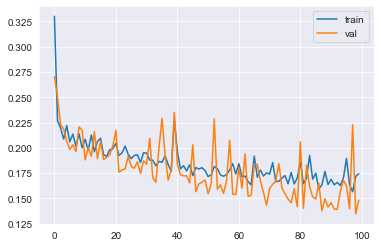

In [16]:
sns.lineplot(range(len(history.history['loss'])), y=history.history['loss'])
sns.lineplot(range(len(history.history['loss'])), y=history.history['val_loss'])
plt.legend(['train', 'val']);

C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


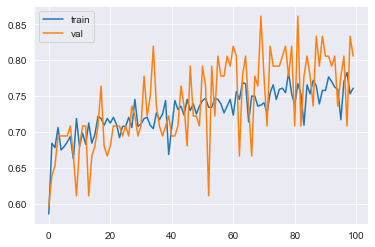

In [17]:
sns.lineplot(range(len(history.history['accuracy'])), y=history.history['accuracy'])
sns.lineplot(range(len(history.history['accuracy'])), y=history.history['val_accuracy'])
plt.legend(['train', 'val']);

In [18]:
# Dajemy naszemu modelowi dane do przewidzenia i porównujemy wyniki z rzeczywistymi
pred = model.predict(X_test) > 0.5
cm = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f_score = f1_score(y_test, pred)

print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1_score: {}'.format(
        acc, precision, recall, f_score))

Accuracy: 0.8156424581005587
Precision: 0.7741935483870968
Recall: 0.7164179104477612
F1_score: 0.7441860465116278


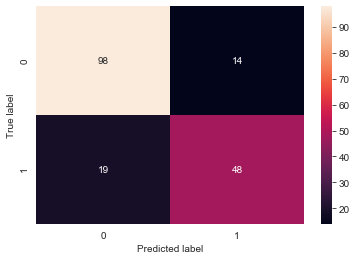

In [19]:
sns.heatmap(cm, annot=True, fmt='')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
# Tworzymy większy model z Dropoutem Dzięki czemu lepiej generalizuje
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True, validation_split=0.1)

Train on 640 samples, validate on 72 samples
Epoch 1/100
640/640 [==============================] - 1s 2ms/sample - loss: 0.7104 - accuracy: 0.6078 - val_loss: 0.6473 - val_accuracy: 0.6111
Epoch 2/100
640/640 [==============================] - 0s 127us/sample - loss: 0.7089 - accuracy: 0.6234 - val_loss: 0.6543 - val_accuracy: 0.5972
Epoch 3/100
640/640 [==============================] - 0s 180us/sample - loss: 0.6476 - accuracy: 0.6234 - val_loss: 0.6469 - val_accuracy: 0.5694
Epoch 4/100
640/640 [==============================] - 0s 167us/sample - loss: 0.6759 - accuracy: 0.6438 - val_loss: 0.6297 - val_accuracy: 0.5972
Epoch 5/100
640/640 [==============================] - 0s 156us/sample - loss: 0.6440 - accuracy: 0.6156 - val_loss: 0.6156 - val_accuracy: 0.6250
Epoch 6/100
640/640 [==============================] - 0s 128us/sample - loss: 0.6316 - accuracy: 0.6562 - val_loss: 0.6056 - val_accuracy: 0.6250
Epoch 7/100
640/640 [==============================] - 0s 151us/sample - lo

640/640 [==============================] - 0s 143us/sample - loss: 0.4443 - accuracy: 0.8250 - val_loss: 0.3590 - val_accuracy: 0.8472
Epoch 57/100
640/640 [==============================] - 0s 122us/sample - loss: 0.4473 - accuracy: 0.8094 - val_loss: 0.3776 - val_accuracy: 0.8611
Epoch 58/100
640/640 [==============================] - 0s 132us/sample - loss: 0.4385 - accuracy: 0.8188 - val_loss: 0.3694 - val_accuracy: 0.8611
Epoch 59/100
640/640 [==============================] - 0s 129us/sample - loss: 0.4377 - accuracy: 0.8188 - val_loss: 0.3564 - val_accuracy: 0.8750
Epoch 60/100
640/640 [==============================] - 0s 134us/sample - loss: 0.4382 - accuracy: 0.8125 - val_loss: 0.3494 - val_accuracy: 0.8750
Epoch 61/100
640/640 [==============================] - 0s 132us/sample - loss: 0.4493 - accuracy: 0.8156 - val_loss: 0.3516 - val_accuracy: 0.8611
Epoch 62/100
640/640 [==============================] - 0s 164us/sample - loss: 0.4507 - accuracy: 0.8203 - val_loss: 0.3573 

C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


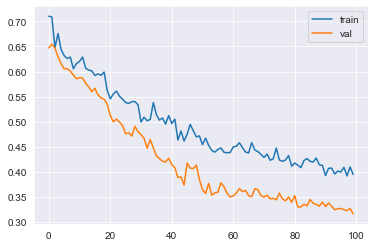

In [23]:
sns.lineplot(range(len(history.history['loss'])), y=history.history['loss'])
sns.lineplot(range(len(history.history['loss'])), y=history.history['val_loss'])
plt.legend(['train', 'val']);

C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\macie\Miniconda3\envs\govtech\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


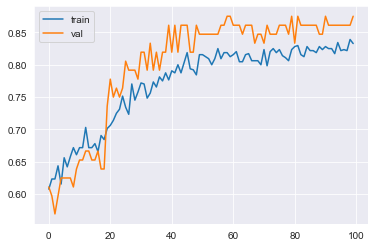

In [24]:
sns.lineplot(range(len(history.history['accuracy'])), y=history.history['accuracy'])
sns.lineplot(range(len(history.history['accuracy'])), y=history.history['val_accuracy'])
plt.legend(['train', 'val']);

In [25]:
# Dajemy naszemu modelowi dane do przewidzenia i porównujemy wyniki z rzeczywistymi
pred = model.predict(X_test) > 0.5
cm = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f_score = f1_score(y_test, pred)

print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1_score: {}'.format(
        acc, precision, recall, f_score))

Accuracy: 0.8100558659217877
Precision: 0.7619047619047619
Recall: 0.7164179104477612
F1_score: 0.7384615384615385


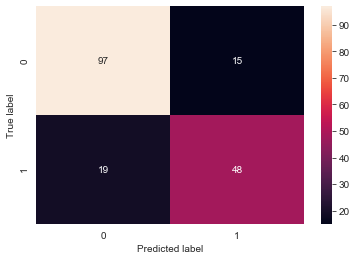

In [26]:
sns.heatmap(cm, annot=True, fmt='')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()